# Introduction to Pit30M

Welcome to Pit30M! To get started, go through these tutorial notebooks in order.


Note that you don't need to download anything---the `pit30m` development kit is cloud-native, which means you can use it to directly access the dataset. There are good reasons for this--the total dataset size is well over 100TB!


### Technical Notes
But don't worry, the dataset has been designed to be cloud-friendly. For example, we provide a PyTorch dataloader which can be used to train and evaluate various models (deep or non-deep). Even modest AWS instances can read hundreds of images a second using the devkit, obviating the need for local copies.

In terms of **programming languages**, while the devkit and related tooling is all Python, as Python has become the *lingua franca* of computer vision and machine learning in the recent years, the devkit is structured in plain formats like individual images files, CSV files, etc., so it can be read from any language which can talk to S3 (so, most languages).

If you do want to copy the dataset, you can always use the [AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-quickstart.html) to `aws s3 sync ...` all or parts of the dataset to wherever you like, such as an on-prem cluster. However, using S3 is recommended due to its speed, space efficiency, and convenience.


### AWS Open Data
AWS provides credit initiatives to researchers interested in working with open datasets (TBD links - ask AWS contacts!)


### Credits
The set of tutorials is inspired by the great documentation of [the Boreas dataset](https://www.boreas.utias.utoronto.ca/).

In [1]:
# TODO(andrei): Remove this cell once we set up a proper Python package.
# The cell assumes we ran the jupyter notebook from the devkit repo root.
import os
import sys
pth = os.path.realpath("../")
sys.path.append(pth)
print(sys.executable)

/home/andrei/miniconda3/envs/devkit309-dev/bin/python


In [2]:
import matplotlib.pyplot as plt
import numpy as np 

%matplotlib inline

from pit30m.data.log_reader import LogReader
from pit30m.camera import CamName

## Reading Images

We will now show how to do basic I/O using the low-level interface of Pit30M: the log reader. In later tutorials we will check out some more interesting abstractions, like leveraging a PyTorch dataloader to read data in parallel at scale for evaluating computer vision algorithms, doing 3D reconstruction, or training neural networks.

In [5]:
# TODO(andrei): Put the final AWS URI here once allocated.
# log_root_uri = "/mnt/data/pit30m/out/sample_out_v6/01d09d4c-329a-4952-f2ed-555aa76dab2c"
log_root_uri = "/mnt/data/pit30m/sagemaker-demo-v0/01d09d4c-329a-4952-f2ed-555aa76dab2c"
# This bucket has only a tiny, tiny subsample of the data for demo purposes. 
#
# log_root_uri = "s3://pit30m-development-v0/logs/01d09d4c-329a-4952-f2ed-555aa76dab2c/"
lr = LogReader(log_root_uri)
# log_root_uri = "/mnt/data/pit30m/out/sample_out_v6/0209f084-2efb-4acf-f2ce-e8f8a58c8b06"
# lr = LogReader(log_root_uri)

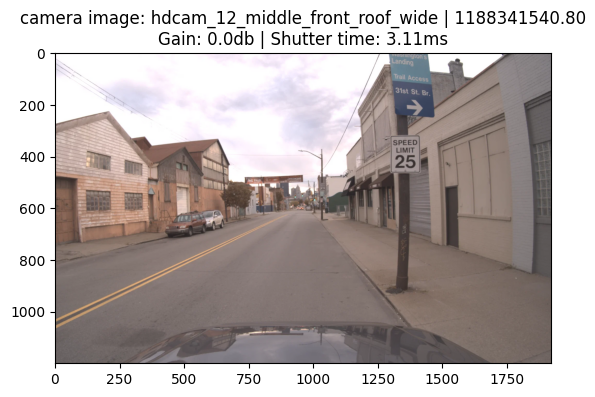

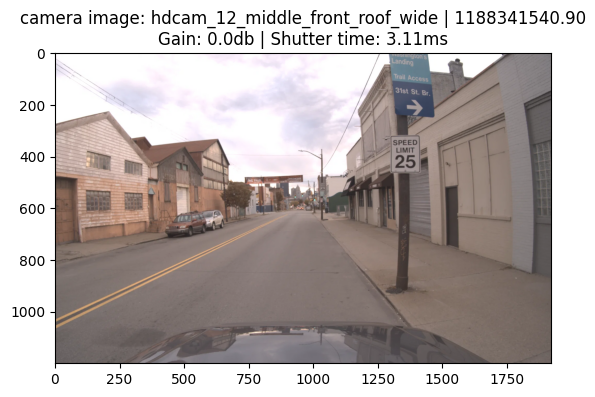

In [6]:
cam_it = lr.camera_iterator(CamName.MIDDLE_FRONT_WIDE)
for idx, cam_img in enumerate(cam_it):
    if idx >= 2:
        break
    
    plt.figure()
    plt.imshow(cam_img.img)
    plt.title(f"camera image: {cam_img.cam_name.value} | {cam_img.capture_timestamp:.2f}\n" \
              f"Gain: {cam_img.gain_db}db | Shutter time: {cam_img.shutter_time_s * 1000:.2f}ms")

# Reading (Lots of) Poses

In [1]:
import folium

gps_track_lonlat = lr.wgs84_poses_dense[:, (2, 1)]
gps_times = lr.wgs84_poses_dense[:, 0]
centroid = np.median(gps_track_lonlat, axis=0)
print(centroid)

# TODO(andrei): Plot WGS84 alongside nice MRP to highlight GPS drift
# TODO(andrei): Use path plotting since it looks way better when we downsample.
m = folium.Map(location=centroid, zoom_start=15)
# Avoid making folium too slow
sample_rate = 5
for gps_timestamp, (lon, lat) in zip(gps_times[::sample_rate], gps_track_lonlat[::sample_rate]):
    popup = f"{lr.log_id}, GPS time {gps_timestamp}"
    folium.CircleMarker(radius=2, location=(lon, lat), popup=popup).add_to(m)

m

NameError: name 'lr' is not defined

## Reading LiDAR

Let's now iterate through a log's LiDAR data and visualize it.

For convenience, we use `matplotlib` for a "hello world" view of the LiDAR. For any larger scale visualization, we strongly encourage the use of `open3d` which can support GPU-accelerated large-scale visualization tens or hundreds of times faster than matplotlib. In practice, you can visualize >100 sweeps at once without any downsampling at 60 FPS on a decent GPU, whereas matplotlib struggles with even just one sweep most of the time.

In [ ]:
%matplotlib notebook


lidar_it = lr.lidar_iterator()
left_camera_it = lr.camera_iterator(CamName.PORT_FRONT_WIDE)
right_camera_it = lr.camera_iterator(CamName.STARBOARD_FRONT_WIDE)
mid_camera_it = lr.camera_iterator(CamName.MIDDLE_FRONT_WIDE)
c_l  = next(left_camera_it)
c_r  = next(right_camera_it)
c_m  = next(mid_camera_it)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(c_l.img)
plt.title(c_l.capture_timestamp)

plt.subplot(1, 3, 2)
plt.imshow(c_m.img)
plt.title(c_m.capture_timestamp)

plt.subplot(1, 3, 3)
plt.imshow(c_r.img)
plt.title(c_r.capture_timestamp)

sweep_0 = next(lidar_it)
sweep_1 = next(lidar_it)

print(sweep_0.point_times.mean())
xyz = sweep_0.xyz_sensor
mask = (xyz[:, 0] < 30) & (xyz[:, 0] > -30)
mask = mask & (xyz[:, 1] < 40) & (xyz[:, 1] > -40)
xyz = xyz[mask, ...]
figsize = (9, 4)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection='3d')
ax.scatter(
    xs=xyz[::5, 0],
    ys=xyz[::5, 1],
    zs=xyz[::5, 2],
    s=0.33,
)
ax.set_aspect("equal")

## Putting It All Together


TODO(andrei): This is too advanced for an intro, we should do an extra tutorial on continuous time modeling.

Important note: The LiDAR exhibits a rolling shutter effect, as it takes 100ms to spin its full 360 horizontal
range.

This means we need to be careful how we map between different cameras and the LiDAR. For any given sweep, if 
we want the best alignment between cameras and LiDAR, we need to grab the camera image corresponding to the time
the LIDAR was sweeping around that part of the scene.




In [ ]:
# Grab a bunch of data so we manually grab the right cam and right sweep, until I get proper support
# for it in the devkit itself.
first_sweeps = []
first_cams = []

cam = CamName.MIDDLE_FRONT_WIDE
lidar_it = lr.lidar_iterator()
cam_it = lr.camera_iterator(cam_name=cam)

for _ in range(100):
    first_sweeps.append(next(lidar_it))
    first_cams.append(next(cam_it))


In [ ]:
reference_lidar = first_sweeps[1]
print(reference_lidar.xyz_continuous.shape)
print(reference_lidar.xyz_sensor.shape)
print(reference_lidar.point_times.shape)

lidar_start = reference_lidar.point_times.min()
lidar_end = reference_lidar.point_times.max()
lidar_mean = reference_lidar.point_times.mean()

print(lidar_start)
print(lidar_end)

# Eyeballed but we can automate this with a joint iterator
# reference_image = first_cams[25]
reference_image = first_cams[26]
print(reference_image.capture_timestamp)

In [ ]:
%matplotlib inline

#
#
calib = lr.calib()["MONOCULAR_RECTIFIED"][cam.value]
# print(calib)

# TODO(andrei): Parse this from 'raw_calibration.yml' automatically.
# right now this is manually computed; loading up the YAML is not hard, and I could even cache all 
# calibration values in a simple JSON file for efficiency.
#
# This transform is hardcoded for: log ID 01d09d4c-329a-4952-f2ed-555aa76dab2c
lidar_to_veh = np.array([
    [1.0, 0.0, 0.0, 1.3982],
    [0.0, 1.0, 0.0, 0.0000],
    [0.0, 0.0, 1.0, 1.92135],
    [0.0, 0.0, 0.0, 1.0],
])

cam_to_veh = calib["sensor_to_vehicle"]
cam_K = calib["camera_matrix"]
print(lidar_to_veh)
print(lidar_to_veh.shape)
print(cam_to_veh)
print(cam_K)

In [ ]:
width = 1920
height = 1200

xyz_lidar = reference_lidar.xyz_sensor
xyz_lidar = np.hstack((xyz_lidar, np.ones(shape=(len(xyz_lidar), 1))))
print(xyz_lidar.shape)
xyz_veh = np.dot(lidar_to_veh, xyz_lidar.T).T
print(xyz_veh.shape)

print(cam_to_veh.dtype)
veh_to_cam = np.linalg.inv(cam_to_veh) 
xyz_cam = np.dot(veh_to_cam, xyz_veh.T).T
print(xyz_cam[:, 3].min(), xyz_cam[:, 3].max())

xyz_cam = xyz_cam[:, :3]
print(xyz_cam.shape)
xyz_im = np.dot(cam_K, xyz_cam.T).T
print(xyz_im.shape)

# Filter to only keep stuff in front of the camera
xyz_im = xyz_im[xyz_im[:, 2] > 0.25, :]
lidar_range = xyz_im[:, 2]
xyz_im = xyz_im[:, :2] / xyz_im[:, 2, None]


mask = (xyz_im[:, 0] > 0) & (xyz_im[:, 0] < width) & \
       (xyz_im[:, 1] > 0) & (xyz_im[:, 1] < height)


xyz_im = xyz_im[mask, :]
lidar_range = lidar_range[mask]
print(xyz_im.shape)

print(np.median(xyz_im, axis=0))

In [ ]:
plt.figure(figsize=(12, 6))
plt.imshow(reference_image.img)
range_col = np.tile(lidar_range[:, None], (1, 3))
range_col = range_col / range_col.max()
range_col = range_col ** 0.5
range_col[:, 2] = 0
range_col = np.hstack(
    (range_col, np.ones(shape=(len(range_col), 1)) * 0.33)
)
print(range_col.shape)
plt.scatter(xyz_im[:, 0], xyz_im[:, 1], s=1, color=range_col)